### In this notebook, we generate results for multiple thresholds on containment fraction.

In [130]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

In [131]:
training = pd.read_csv('training-simplified-data-generation.csv')
test = pd.read_csv('test-simplified-data-generation.csv')

#### Let's (sanity-)check how many candidates per query there are in these datasets.

In [132]:
training_queries = set(training['query'])
test_queries = set(test['query'])

In [133]:
len(training_queries) == training.shape[0]

True

In [134]:
len(test_queries) == test.shape[0]

True

#### Ok. So there's no overlap in query features in both the training and the test set, which is good for our current analyses.

In [135]:
training_queries & test_queries

set()

#### Alright. So if there's no overlap, we can generate different versions of these datasets based on distinct containment ratio thresholds $\theta$.

In [136]:
THRESHOLDS = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5,
              0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
def generate_different_dataset_versions(dataset):
    pruned_datasets = []
    for thresh in THRESHOLDS:
        pruned_datasets.append(dataset.loc[dataset['containment_fraction'] >= thresh])
    return pruned_datasets

In [137]:
training_datasets_different_theta = generate_different_dataset_versions(training)

In [138]:
test_datasets_different_theta = generate_different_dataset_versions(test)

#### Now, let's train and test taking the thresholds into account.

In [139]:
FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio',
                'query_max_skewness', 'query_max_kurtosis', 'query_max_unique', 
                'candidate_num_rows', 'candidate_max_skewness', 'candidate_max_kurtosis',
                'candidate_max_unique', 'query_target_max_pearson', 
                'query_target_max_spearman', 'query_target_max_covariance', 
                'query_target_max_mutual_info', 'candidate_target_max_pearson', 
                'candidate_target_max_spearman', 'candidate_target_max_covariance', 
                'candidate_target_max_mutual_info']

In [140]:
from sklearn.preprocessing import StandardScaler

NORMALIZABLE_FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio',
                'query_max_skewness', 'query_max_kurtosis', 'query_max_unique', 
                'candidate_num_rows', 'candidate_max_skewness', 'candidate_max_kurtosis',
                'candidate_max_unique', 'query_target_max_covariance', 
                'query_target_max_mutual_info', 'candidate_target_max_covariance', 
                'candidate_target_max_mutual_info']

def normalize_dataset(dataset):
    standard_scaler = StandardScaler()
    for feature in NORMALIZABLE_FEATURES:
        dataset[feature] = standard_scaler.fit_transform(np.array(dataset[feature]).reshape(-1, 1))
    return dataset

#### I'm adding a simple normalization method here but I'm not sure about how we should use it to normalize test data. Should we normalize candidate features considering only candidates for a same query? And how should we normalize the query features (I know there's only one candidate per query here, but there are cases where there are many)? In a practical scenario, we only get one query at a time, so we won't have much of a "reference" against which we can normalize query features.

In [141]:
def calculate_performance_for_different_training_and_test_pairs(training_datasets, test_datasets):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    for training, test in zip(training_datasets, test_datasets):
        normed_training = normalize_dataset(training)
        normed_training['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in normed_training.iterrows()]
        normed_test = normalize_dataset(test)
        normed_test['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in normed_test.iterrows()]
        rf.fit(normed_training[FEATURES], normed_training['class'])
        preds = rf.predict(normed_test[FEATURES])
        print(classification_report(normed_test['class'], preds))

In [142]:
calculate_performance_for_different_training_and_test_pairs(training_datasets_different_theta, test_datasets_different_theta)

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

              precision    recall  f1-score   support

        gain       0.65      0.78      0.71      1960
        loss       0.52      0.37      0.43      1305

   micro avg       0.61      0.61      0.61      3265
   macro avg       0.59      0.57      0.57      3265
weighted avg       0.60      0.61      0.60      3265

              precision    recall  f1-score   support

        gain       0.65      0.78      0.71      1962
        loss       0.52      0.35      0.42      1310

   micro avg       0.61      0.61      0.61      3272
   macro avg       0.58      0.57      0.56      3272
weighted avg       0.60      0.61      0.59      3272

              precision    recall  f1-score   support

        gain       0.65      0.78      0.71      1967
        loss       0.53      0.37      0.44      1314

   micro avg       0.62      0.62      0.62      3281
   macro avg       0.59      0.58      0.57      3281
weighted avg       0.60      0.62      0.60      3281

              preci

In [182]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fmeasures_and_supports(fmeasures, supports, title):
  fig, ax1 = plt.subplots()
  color = '#1d3557'
  ax1.set_xlabel(r'Threshold $\theta$')
  ax1.xaxis.label.set_size(16)
  #ax1.set_xlim(xmin=0.248,xmax=0.652)
  #extraticks = [0.25, 0.35, 0.45, 0.55, 0.65]
  #ax1.set_xticks(extraticks) #list(ax1.get_xticks()) +
  ax1.set_ylabel(r'Support', color=color) # ($\ln$)
  ax1.yaxis.label.set_size(16)
  ax1.plot(THRESHOLDS, supports, 'o--', dashes=(5,10), color=color, linewidth=3, label='support')
  ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
  ax1.tick_params(axis='x',  labelsize=12)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  #ax2.set_xlim(xmin=0.248,xmax=0.652)
  ax2.xaxis.label.set_size(16)
  #ax2.set_xticks(list(ax2.get_xticks()) + extraticks)
  color = '#e63946'
  ax2.set_ylabel(r'F-measure', color=color)  # we already handled the x-label with ax1
  ax2.yaxis.label.set_size(16)
  #ax2.set_ylim(ymin=0.475,ymax=0.585)
  ax2.plot(THRESHOLDS, fmeasures, 'o-', color=color, linewidth=3, label='f-measure')
  ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
  ax2.tick_params(axis='x',  labelsize=12)
  plt.title(title)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.savefig('varying-containment.png', dpi=600)
  plt.show()


#### Note that the f-score increases as the containment ratio threshold increases as well... Let's plot support and f-measure.

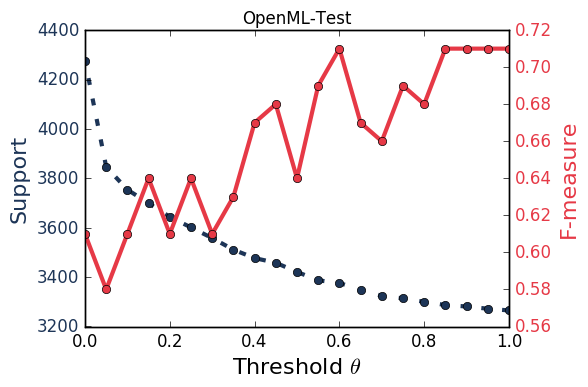

In [184]:
fmeasures = [0.71, 0.71, 0.71, 0.71, 0.68, 0.69, 0.66, 0.67, 0.71, 
             0.69, 0.64, 0.68, 0.67, 0.63, 0.61, 0.64, 0.61, 0.64, 0.61, 0.58, 0.61]
positive_supports = [1960, 1962, 1967, 1972, 1977, 1983, 1991, 2007, 2026, 2030, 2050, 2072, 
            2082, 2101, 2126, 2145, 2161, 2197, 2227, 2267, 2496]
supports = [3265, 3272, 3281, 3287, 3300, 3314, 3324, 3349, 3376, 3387, 3421, 3458,
            3477, 3511, 3558, 3601, 3644, 3699, 3754, 3846, 4276]
plot_fmeasures_and_supports(fmeasures, supports, 'OpenML-Test')

#### Note that there is an ascending trend in the F-Measure, but it is hard to know where to "cut" here: 0.3? 0.4? 0.5? For now, we'll use $\theta$ == 0.6 for all experiments.

In [147]:
# datasets 

pruned_training = training_datasets_different_theta[8]
pruned_test = test_datasets_different_theta[8]


In [148]:
pruned_training.shape

(7932, 36)

In [149]:
pruned_test.shape

(3376, 36)

In [150]:
pruned_training.loc[pruned_training['class'] == 'gain'].shape


(4774, 36)

In [151]:
pruned_test.loc[pruned_test['class'] == 'gain'].shape

(2026, 36)

#### Let's compare the results we obtained with $\theta$ = 0.6 against other methodologies (one with added noise and one with many candidates per query, both also using threshold $\theta$ = 0.6.

#### It was taking too long to get results for the "many-candidates" methodology on this notebook, so I generated the results on ipython on my terminal and attached them below as text.

In [154]:
THETA = 0.6

training_official = pruned_training

training_noise = pd.read_csv('training-with-noise-data-generation.csv')
training_noise = training_noise.loc[training_noise['containment_fraction'] >= THETA]
training_noise = normalize_dataset(training_noise)
training_noise['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in training_noise.iterrows()]

test = pruned_test

In [155]:
rf_official = RandomForestClassifier(n_estimators=100, random_state=42)
rf_official.fit(training_official[FEATURES], training_official['class'])
preds = rf_official.predict(test[FEATURES])
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.65      0.77      0.71      2026
        loss       0.53      0.39      0.45      1350

   micro avg       0.62      0.62      0.62      3376
   macro avg       0.59      0.58      0.58      3376
weighted avg       0.60      0.62      0.60      3376



In [156]:
rf_noise = RandomForestClassifier(n_estimators=100, random_state=42)
rf_noise.fit(training_noise[FEATURES], training_noise['class'])
preds = rf_noise.predict(test[FEATURES])
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.67      0.58      0.62      2026
        loss       0.48      0.58      0.52      1350

   micro avg       0.58      0.58      0.58      3376
   macro avg       0.58      0.58      0.57      3376
weighted avg       0.59      0.58      0.58      3376



#### Results for "many candidates" methodology:

                precision    recall  f1-score   support

        gain       0.69      0.59      0.63      2026
        loss       0.49      0.60      0.54      1350

    accuracy                           0.59      3376


#### Let's check the percentage of successful and unsuccessful augmentations for all these different datasets

In [158]:
print('training_official -- number of rows', training_official.shape[0], 
      'positive augs', float(training_official.loc[training_official['class'] == 'gain'].shape[0])/training_official.shape[0],
      'negative augs', float(training_official.loc[training_official['class'] == 'loss'].shape[0])/training_official.shape[0])

('training_official -- number of rows', 7932, 'positive augs', 0.6018658598083712, 'negative augs', 0.39813414019162885)


In [160]:
print('test -- number of rows', test.shape[0], 
      'positive augs', float(test.loc[test['class'] == 'gain'].shape[0])/test.shape[0],
      'negative augs', float(test.loc[test['class'] == 'loss'].shape[0])/test.shape[0])

('test -- number of rows', 3376, 'positive augs', 0.6001184834123223, 'negative augs', 0.39988151658767773)


In [161]:
print('training_noise -- number of rows', training_noise.shape[0], 
      'positive augs', float(training_noise.loc[training_noise['class'] == 'gain'].shape[0])/training_noise.shape[0],
      'negative augs', float(training_noise.loc[training_noise['class'] == 'loss'].shape[0])/training_noise.shape[0])

('training_noise -- number of rows', 5013, 'positive augs', 0.5344105326152004, 'negative augs', 0.4655894673847995)


#### For the "many candidates" methodology, we have 1266624 rows, 48% positive and 52% negative. 

#### Let's see which features are most important for rf_official

In [185]:
print(sorted([(i, j) for i, j in zip(FEATURES, rf_official.feature_importances_)],
            key=lambda x: x[1], reverse=True))

[('candidate_target_max_pearson', 0.09849076660016301), ('candidate_target_max_spearman', 0.093891223467264806), ('query_row_column_ratio', 0.084648388295422872), ('candidate_max_kurtosis', 0.072043177646632109), ('candidate_max_skewness', 0.071957849734316112), ('query_target_max_pearson', 0.065146565909157794), ('query_num_of_columns', 0.063862975637207692), ('query_target_max_spearman', 0.063816214443990132), ('query_max_kurtosis', 0.062124549907949252), ('query_max_skewness', 0.05720125836070155), ('candidate_target_max_mutual_info', 0.048621110687740832), ('candidate_max_unique', 0.042091229099697536), ('candidate_num_rows', 0.037575249540447088), ('query_target_max_mutual_info', 0.036941819371807606), ('query_max_unique', 0.036890812702596948), ('query_num_of_rows', 0.024573660137982397), ('query_target_max_covariance', 0.021799436516301448), ('candidate_target_max_covariance', 0.018323711940620838)]


#### Let's compare rf_official with a few baselines now. Let's start with a hierarchical one.

In [191]:
DATASET_QUERY_FEATURES = ['query_target_max_pearson', 
                'query_target_max_spearman', 'query_target_max_covariance', 
                'query_target_max_mutual_info', 'candidate_target_max_pearson', 
                'candidate_target_max_spearman', 'candidate_target_max_covariance', 
                'candidate_target_max_mutual_info']

DATASET_FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio',
                'query_max_skewness', 'query_max_kurtosis', 'query_max_unique', 
                'candidate_num_rows', 'candidate_max_skewness', 'candidate_max_kurtosis',
                'candidate_max_unique']


rf_dataset_query_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_dataset_query_features.fit(training_official[DATASET_QUERY_FEATURES], training_official['class'])
preds_dataset_query_features = rf_dataset_query_features.predict(test[DATASET_QUERY_FEATURES])

rf_dataset_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_dataset_features.fit(training_official[DATASET_FEATURES], training_official['class'])
preds_dataset_features = rf_dataset_features.predict(test[DATASET_FEATURES])

preds = ['gain' if i == 'gain' and j == 'gain' else 'loss' for i, j in zip(preds_dataset_query_features, preds_dataset_features)]
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.65      0.47      0.54      2026
        loss       0.44      0.62      0.51      1350

   micro avg       0.53      0.53      0.53      3376
   macro avg       0.54      0.54      0.53      3376
weighted avg       0.56      0.53      0.53      3376



In [202]:
from scipy.spatial.distance import euclidean
import random

positive_centroid = training_official.loc[training_official['class'] == 'gain'][FEATURES].mean()
negative_centroid = training_official.loc[training_official['class'] == 'loss'][FEATURES].mean()

preds = []
for index, row in test.iterrows():
    dist_pos = euclidean(positive_centroid, row[FEATURES])
    dist_neg = euclidean(negative_centroid, row[FEATURES])
    if dist_pos < dist_neg:
        preds.append('gain')
    else: 
        preds.append('loss')
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.66      0.63      0.65      2026
        loss       0.48      0.52      0.50      1350

   micro avg       0.59      0.59      0.59      3376
   macro avg       0.57      0.58      0.57      3376
weighted avg       0.59      0.59      0.59      3376



#### Now let's check the probability distribution of predictions for test with rf_official

In [205]:
preds_proba = [i[0] for i in rf_official.predict_proba(test[FEATURES])]
print(preds_proba)

[0.54000000000000004, 0.53000000000000003, 0.54000000000000004, 0.56999999999999995, 0.48999999999999999, 0.56000000000000005, 0.52000000000000002, 0.56999999999999995, 0.69999999999999996, 0.51000000000000001, 0.44, 0.60999999999999999, 0.66000000000000003, 0.40999999999999998, 0.53000000000000003, 0.69499999999999995, 0.48999999999999999, 0.59166666666666667, 0.83999999999999997, 0.77000000000000002, 0.53000000000000003, 0.63, 0.57999999999999996, 0.44, 0.42999999999999999, 0.46000000000000002, 0.46999999999999997, 0.56999999999999995, 0.49333333333333335, 0.55333333333333323, 0.54000000000000004, 0.45000000000000001, 0.79000000000000004, 0.46000000000000002, 0.58999999999999997, 0.68999999999999995, 0.44500000000000001, 0.48999999999999999, 0.41999999999999998, 0.68000000000000005, 0.47999999999999998, 0.55333333333333323, 0.57999999999999996, 0.48999999999999999, 0.46999999999999997, 0.47999999999999998, 0.78000000000000003, 0.47999999999999998, 0.53000000000000003, 0.7125000000000

In [207]:
probs_hist = [len([i for i in preds_proba if i < 0.05]),
              len([i for i in preds_proba if i >= 0.05 and i < 0.1]),
              len([i for i in preds_proba if i >= 0.1 and i < 0.15]),
              len([i for i in preds_proba if i >= 0.15 and i < 0.2]),
              len([i for i in preds_proba if i >= 0.2 and i < 0.25]),
              len([i for i in preds_proba if i >= 0.25 and i < 0.3]),
              len([i for i in preds_proba if i >= 0.3 and i < 0.35]),
              len([i for i in preds_proba if i >= 0.35 and i < 0.4]),
              len([i for i in preds_proba if i >= 0.4 and i < 0.45]),
              len([i for i in preds_proba if i >= 0.45 and i < 0.5]),
              len([i for i in preds_proba if i >= 0.5 and i < 0.55]),
              len([i for i in preds_proba if i >= 0.55 and i < 0.6]),
              len([i for i in preds_proba if i >= 0.6 and i < 0.65]),
              len([i for i in preds_proba if i >= 0.65 and i < 0.7]),
              len([i for i in preds_proba if i >= 0.7 and i < 0.75]),
              len([i for i in preds_proba if i >= 0.75 and i < 0.8]),
              len([i for i in preds_proba if i >= 0.8 and i < 0.85]),
              len([i for i in preds_proba if i >= 0.85 and i < 0.9]),
              len([i for i in preds_proba if i >= 0.9 and i < 0.95]),
              len([i for i in preds_proba if i >= 0.95 and i <= 1])]
print([i for i in probs_hist])

[0, 0, 0, 0, 0, 2, 11, 77, 305, 597, 797, 617, 340, 242, 181, 107, 47, 28, 21, 4]


In [211]:
(597+797)/float(sum(probs_hist))

0.41291469194312796

In [209]:
test['official_preds'] = preds
test['official_preds_proba'] = preds_proba
certain_test = test.loc[(test['official_preds_proba'] < 0.45) | (test['official_preds_proba'] > 0.55)]
print(classification_report(certain_test['class'], certain_test['official_preds']))

              precision    recall  f1-score   support

        gain       0.75      0.72      0.73      1242
        loss       0.47      0.50      0.48       609

   micro avg       0.65      0.65      0.65      1851
   macro avg       0.61      0.61      0.61      1851
weighted avg       0.65      0.65      0.65      1851



In [213]:
fp = test.loc[(test['class'] == 'loss') | (test['official_preds'] == 'gain')].shape[0]
fn = test.loc[(test['class'] == 'gain') | (test['official_preds'] == 'loss')].shape[0]

certain_fp = certain_test.loc[(certain_test['class'] == 'loss') | (certain_test['official_preds'] == 'gain')].shape[0]
certain_fn = certain_test.loc[(certain_test['class'] == 'gain') | (certain_test['official_preds'] == 'loss')].shape[0]
print(certain_fp/float(fp), certain_fn/float(fn))

(0.5742083174360931, 0.5655197657393851)
